In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
symcol = {}
symcol['V']  = 'black'
symcol['U']  = 'blue'
symcol['F']  = 'green'
symcol['Ce'] = 'dodgerblue'
symcol['An'] = 'olive'
symcol['Pe'] = 'darkgreen'
symcol['Hy'] = 'm'
symcol['A2'] = 'darkgoldenrod'
symcol['N41'] = 'orchid'
symcol['N5'] = 'firebrick'
symcol['Ca'] = 'sienna'
symcol['N8'] = 'slateblue'
symcol['N7'] = 'chocolate'
symcol['A1'] = 'red'
symcol['Co'] = 'maroon'
symcol['A4'] = 'deeppink'
symcol['N40']= 'magenta'
symcol['A5'] = 'crimson'
symcol['A26'] = 'purple'
symcol['He'] = 'indigo'

In [4]:
def getMagLim(slope, zp, Mi_lim = -17, band = 'i'):
    
    if band=='u':
        alpha = 2.68
        beta = 1.58
        w_ = (zp-beta-Mi_lim)/(alpha-slope)
        Mlim = slope * w_ + zp
        return Mlim
    elif band=='g':
        alpha = 0.84
        beta = 0.64
        w_ = (zp-beta-Mi_lim)/(alpha-slope)
        Mlim = slope * w_ + zp
        return Mlim
    elif band=='r':
        alpha = 0.27
        beta = 0.23
        w_ = (zp-beta-Mi_lim)/(alpha-slope)
        Mlim = slope * w_ + zp
        return Mlim
    elif band=='i':
        Mlim = Mi_lim
        return Mlim
    elif band=='z':
        alpha = 0.25
        beta = 0.12
        w_ = (zp+beta-Mi_lim)/(-alpha-slope)
        Mlim = slope * w_ + zp
        return Mlim    
    elif band=='w1':
#         alpha = 1.18
#         beta = -0.47
#         w_ = (zp+beta-Mi_lim)/(-alpha-slope)
        Mlim = -16.1
        return Mlim  
    elif band=='w2':
#         alpha = 1.32
#         beta = -1.04
#         w_ = (zp+beta-Mi_lim)/(-alpha-slope)
        Mlim = -15.5
        return Mlim   

In [5]:
def add2Dict0(myDict, code, band, Mlim):
    
    if not code in myDict:
        myDict[code]={}
    myDict[code][band]= Mlim

table   = np.genfromtxt('cluster_code_Mlimit_revised.csv' , delimiter=',', 
                        filling_values=0, names=True, dtype=None, encoding=None)

mag_lims_u = table['u']
mag_lims_g = table['g']
mag_lims_r = table['r']
mag_lims_i = table['i']
mag_lims_z = table['z']
mag_lims_w1 = table['w1']
mag_lims_w2 = table['w2']
code = table['Code']  
Mlim_dict = {} 

for i, myCode in enumerate(code):
    myCode = myCode.strip()
    add2Dict0(Mlim_dict, myCode, 'u', mag_lims_u[i])
    add2Dict0(Mlim_dict, myCode, 'g', mag_lims_g[i])
    add2Dict0(Mlim_dict, myCode, 'r', mag_lims_r[i])
    add2Dict0(Mlim_dict, myCode, 'i', mag_lims_i[i])
    add2Dict0(Mlim_dict, myCode, 'z', mag_lims_z[i])
    add2Dict0(Mlim_dict, myCode, 'w1', mag_lims_w1[i])
    add2Dict0(Mlim_dict, myCode, 'w2', mag_lims_w2[i])
    
##############################################
table   = np.genfromtxt('band_gamma_rho.csv' , delimiter=',', 
                        filling_values=0, names=True, dtype=None, encoding=None)
band = table['band'] 
param = table['param'] 
rho = table['rho'] 
gamma = table['gamma'] 
gamma_rho_dict = {} 

for i, myband in enumerate(band):
    myband = myband.strip()
    add2Dict0(gamma_rho_dict, myband, param[i].strip(),[rho[i], gamma[i]])

In [6]:
def getVmod(key):

    if key == 'NEST_100002':  # Virgo
        return 1516., 45.
    if key == 'NEST_100008':  # U Ma
        return 1141., 13.
    if key == 'NEST_200015':  # Fornax
        return 1383., 32. 
    if key == 'NEST_200092':  # Pegasus
        return 3249., 61.
    if key == 'NEST_100003':  # Centaurus
        return 3645., 56.    
    if key == 'NEST_100014':  # Antlia
        return 3103., 53.
    if key == 'NEST_100006':  # Hydra
        return 4084., 44.    
    if key == 'NEST_200003':  # A 262
        return 4684., 50.
    if key == 'NEST_200006':  # N 507
        return 4660., 64.      
    if key == 'NEST_200005':  # N 410
        return 4792., 53.
    if key == 'NEST_100030':  # Cancer
        return 5025., 71.    
    if key == 'NEST_200045':  # N 80
        return 5499., 42. 
    if key == 'NEST_200037':  # N 70
        return 6619., 80.     
    if key == 'NEST_100005':  # A 1367
        return 7060., 61.    
    if key == 'NEST_100001':  # Coma
        return 7352., 70.
    if key == 'NEST_200012':  # A 400
        return 7357., 85. 
    if key == 'NEST_100018':  # N 4065
        return 7501., 63.
    if key == 'NEST_200017':  # A 539
        return 8995., 87.
    if key == 'NEST_200016':  # A 2634/66
        return 8954., 98.
    if key == 'NEST_100007':  # Hercules
        return 11353., 121.      
        

In [7]:
I_maglim = [5807393, 5807403, 5057729, 5059653, 4126669, 5059227, 38803, 39181, 39431, 39619, 39655, 40005, 40107, 40147, 40588, 40604, 41567, 41829, 42768, 41440, 37814, 39344, 13756, 14548, 14590]
calib_maglim = [3974, 6699, 19871, 22277, 38148, 41020, 41066, 41093, 46127, 49448, 53641, 28378, 6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 41066, 44982, 45084, 46127, 49448, 53641, 67908, 72228, 21102, 50073]


########### Updated list using the color-LogWimx correaltion


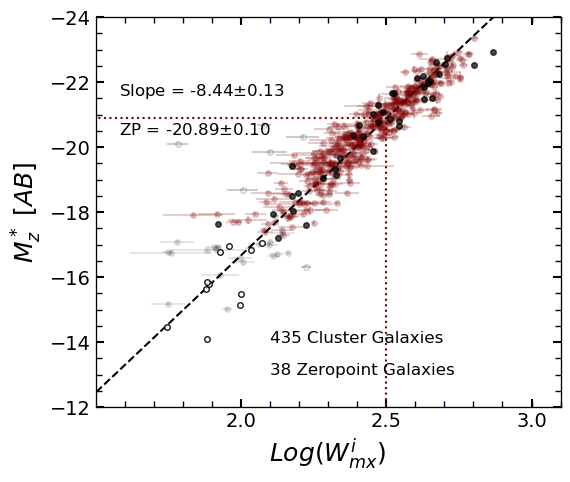

In [138]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)



ctl   = np.genfromtxt('allzpa_labels.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
dist = 10**((ctl['dm19']-25)/5)  
manualInput_all = (PGC,ID,dist)

# ctl   = np.genfromtxt('TFcal_ZP_trgb2.81.rizzi.csv' , delimiter=',', filling_values=-1, 
#                       names=True, dtype=None, encoding=None)
# PGC  = ctl['PGC']
# ID   = ctl['Name']
# dist = 10**((ctl['dmtriz']-25)/5) 
# manualInput_rizzi = (PGC,ID,dist)



# ctl   = np.genfromtxt('TFcal_ZP_cepheids2.33.csv' , delimiter=',', filling_values=-1, 
#                       names=True, dtype=None, encoding=None)
# PGC  = ctl['PGC']
# ID   = ctl['Name']
# dist = 10**((ctl['dmc19']-25)/5) 
# manualInput_cepheids = (PGC,ID,dist)


band = 'z'

fig, ax, Clusters, S_ZP, zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            addSouth=False,
                                            getZPcalib=True,
                                            OP_IR = False)
#                                             manualInput=manualInput_all
#                                            )

slope = S_ZP[0]
slope_e = S_ZP[1]
zp    = S_ZP[2]
zp_e    = S_ZP[3]

Clusters = update_DM_Clusters(Clusters, zp-0.08, adjustZPerr=0)


In [139]:
def biasFuc2(M, a, b, Mlim=-17):
    
    if M>Mlim:
        return 0.
    return a*(np.abs(M-Mlim))**b


for key in Clusters:
    
    myCluster = Clusters[key]
    Vmod, Vmod_e = getVmod(key)
    
    code = myCluster['code']
    DMo  = myCluster['DMo']
    DMe  = myCluster['zp_e'][0]
    
    Cluster_Mlim = Mlim_dict[code][band] - DMo
    band_lim = getMagLim(slope, zp, band = band)
    rho_gamma = gamma_rho_dict[band]['a']
    rho = rho_gamma[0]
    gamma = rho_gamma[1]
    cluster_bias = biasFuc2(Cluster_Mlim, rho, gamma, Mlim=band_lim)
    
    DM_modified = DMo+cluster_bias  

    
    Dmpc = 10**((DM_modified-25.)/5.)
    Dmpc_e = (DMe*Dmpc*np.log(10))/5
    
    H0 = Vmod/Dmpc
    H0e = H0*np.sqrt(Vmod_e**2/Vmod**2 + Dmpc_e**2/Dmpc**2)

    rowDict = {}
    myCluster['bias']   = cluster_bias
    myCluster['DM']     = DM_modified
    myCluster['DMe']    = DMe
    myCluster['Dmpc']   = Dmpc
    myCluster['Dmpc_e'] = Dmpc_e
    myCluster['H0']     = H0
    myCluster['H0e']    = H0e
    myCluster['Vmod']   = Vmod
    myCluster['Vmod_e'] = Vmod_e


In [140]:

Python 2 Not Trusted
File
Edit
View
Insert
Cell
Kernel
Widgets
Help
￼￼￼￼￼￼￼￼Run￼￼￼￼￼
In [1]:
￼
1
import sys
2
import time
3
import os
4
import subprocess
5
import math
6
import matplotlib.pyplot as plt
7
import numpy as np
8
from astropy.table import Table, Column 
9
from scipy.stats import linregress
10
from scipy import interpolate
11
from scipy import polyval, polyfit
12
from scipy.optimize import curve_fit
13
from scipy import odr
14
import pylab as py
15
from matplotlib import gridspec
16
import sklearn.datasets as ds
17
from sklearn.ensemble import RandomForestRegressor
18
from sklearn.datasets import make_regression
19
import corner
20
import emcee
21
import scipy.optimize as op
22
from scipy.linalg import cholesky, inv,det
23
from scipy.optimize import minimize
24
import random
25
from astropy.table import Table, Column
26
from linear_mcmc import *
27
​
28
from redTools import *
29
from Kcorrect import *
30
from calibTools import *
In [2]:
￼
1
####################################### Set Axes
2
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
3
        
4
        if not ylim is None:
5
            ax.set_ylim(ylim)
6
        else:
7
            ylim = ax.get_ylim() 
8
            
9
        if not xlim is None:    
10
            ax.set_xlim(xlim) 
11
        else:
12
            xlim = ax.get_xlim()
13
            
14
        ax.tick_params(which='major', length=6, width=1., direction=inout)
15
#         if minor:
16
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
17
        
18
        if twiny:
19
            y_ax = ax.twinx()
20
            y_ax.set_ylim(ylim)
21
            y_ax.set_yticklabels([])
22
            y_ax.minorticks_on()
23
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
24
            if minor:
25
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
26
        
27
        if twinx:
28
            x_ax = ax.twiny()
29
            x_ax.set_xlim(xlim)
30
            x_ax.set_xticklabels([])
31
            x_ax.minorticks_on()
32
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
33
            if minor:
34
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     
35
​
36
        for tick in ax.xaxis.get_major_ticks():
37
                    tick.label.set_fontsize(fontsize) 
38
        for tick in ax.yaxis.get_major_ticks():
39
                    tick.label.set_fontsize(fontsize) 
40
        
41
        return x_ax, y_ax
In [3]:
￼
1
symcol = {}
2
symcol['V']  = 'black'
3
symcol['U']  = 'blue'
4
symcol['F']  = 'green'
5
symcol['Ce'] = 'dodgerblue'
6
symcol['An'] = 'olive'
7
symcol['Pe'] = 'darkgreen'
8
symcol['Hy'] = 'm'
9
symcol['A2'] = 'darkgoldenrod'
10
symcol['N41'] = 'orchid'
11
symcol['N5'] = 'firebrick'
12
symcol['Ca'] = 'sienna'
13
symcol['N8'] = 'slateblue'
14
symcol['N7'] = 'chocolate'
15
symcol['A1'] = 'red'
16
symcol['Co'] = 'maroon'
17
symcol['A4'] = 'deeppink'
18
symcol['N40']= 'magenta'
19
symcol['A5'] = 'crimson'
20
symcol['A26'] = 'purple'
21
symcol['He'] = 'indigo'
In [4]:
￼
1
def getMagLim(slope, zp, Mi_lim = -17, band = 'i'):
2
    
3
    if band=='u':
4
        alpha = 2.68
5
        beta = 1.58
6
        w_ = (zp-beta-Mi_lim)/(alpha-slope)
7
        Mlim = slope * w_ + zp
8
        return Mlim
9
    elif band=='g':
10
        alpha = 0.84
11
        beta = 0.64
12
        w_ = (zp-beta-Mi_lim)/(alpha-slope)
13
        Mlim = slope * w_ + zp
14
        return Mlim
15
    elif band=='r':
16
        alpha = 0.27
17
        beta = 0.23
18
        w_ = (zp-beta-Mi_lim)/(alpha-slope)
19
        Mlim = slope * w_ + zp
20
        return Mlim
21
    elif band=='i':
22
        Mlim = Mi_lim
23
        return Mlim
24
    elif band=='z':
25
        alpha = 0.25
26
        beta = 0.12
27
        w_ = (zp+beta-Mi_lim)/(-alpha-slope)
28
        Mlim = slope * w_ + zp
29
        return Mlim    
30
    elif band=='w1':
31
#         alpha = 1.18
32
#         beta = -0.47
33
#         w_ = (zp+beta-Mi_lim)/(-alpha-slope)
34
        Mlim = -16.1
35
        return Mlim  
36
    elif band=='w2':
37
#         alpha = 1.32
38
#         beta = -1.04
39
#         w_ = (zp+beta-Mi_lim)/(-alpha-slope)
40
        Mlim = -15.5
41
        return Mlim   
In [5]:
￼
1
def add2Dict0(myDict, code, band, Mlim):
2
    
3
    if not code in myDict:
4
        myDict[code]={}
5
    myDict[code][band]= Mlim
6
​
7
table   = np.genfromtxt('cluster_code_Mlimit_revised.csv' , delimiter=',', 
8
                        filling_values=0, names=True, dtype=None, encoding=None)
9
​
10
mag_lims_u = table['u']
11
mag_lims_g = table['g']
12
mag_lims_r = table['r']
13
mag_lims_i = table['i']
14
mag_lims_z = table['z']
15
mag_lims_w1 = table['w1']
16
mag_lims_w2 = table['w2']
17
code = table['Code']  
18
Mlim_dict = {} 
19
​
20
for i, myCode in enumerate(code):
21
    myCode = myCode.strip()
22
    add2Dict0(Mlim_dict, myCode, 'u', mag_lims_u[i])
23
    add2Dict0(Mlim_dict, myCode, 'g', mag_lims_g[i])
24
    add2Dict0(Mlim_dict, myCode, 'r', mag_lims_r[i])
25
    add2Dict0(Mlim_dict, myCode, 'i', mag_lims_i[i])
26
    add2Dict0(Mlim_dict, myCode, 'z', mag_lims_z[i])
27
    add2Dict0(Mlim_dict, myCode, 'w1', mag_lims_w1[i])
28
    add2Dict0(Mlim_dict, myCode, 'w2', mag_lims_w2[i])
29
    
30
##############################################
31
table   = np.genfromtxt('band_gamma_rho.csv' , delimiter=',', 
32
                        filling_values=0, names=True, dtype=None, encoding=None)
33
band = table['band'] 
34
param = table['param'] 
35
rho = table['rho'] 
36
gamma = table['gamma'] 
37
gamma_rho_dict = {} 
38
​
39
for i, myband in enumerate(band):
40
    myband = myband.strip()
41
    add2Dict0(gamma_rho_dict, myband, param[i].strip(),[rho[i], gamma[i]])
In [6]:
￼
1
def getVmod(key):
2
​
3
    if key == 'NEST_100002':  # Virgo
4
        return 1516., 45.
5
    if key == 'NEST_100008':  # U Ma
6
        return 1141., 13.
7
    if key == 'NEST_200015':  # Fornax
8
        return 1383., 32. 
9
    if key == 'NEST_200092':  # Pegasus
10
        return 3249., 61.
11
    if key == 'NEST_100003':  # Centaurus
12
        return 3645., 56.    
13
    if key == 'NEST_100014':  # Antlia
14
        return 3103., 53.
15
    if key == 'NEST_100006':  # Hydra
16
        return 4084., 44.    
17
    if key == 'NEST_200003':  # A 262
18
        return 4684., 50.
19
    if key == 'NEST_200006':  # N 507
20
        return 4660., 64.      
21
    if key == 'NEST_200005':  # N 410
22
        return 4792., 53.
23
    if key == 'NEST_100030':  # Cancer
24
        return 5025., 71.    
25
    if key == 'NEST_200045':  # N 80
26
        return 5499., 42. 
27
    if key == 'NEST_200037':  # N 70
28
        return 6619., 80.     
29
    if key == 'NEST_100005':  # A 1367
30
        return 7060., 61.    
31
    if key == 'NEST_100001':  # Coma
32
        return 7352., 70.
33
    if key == 'NEST_200012':  # A 400
34
        return 7357., 85. 
35
    if key == 'NEST_100018':  # N 4065
36
        return 7501., 63.
37
    if key == 'NEST_200017':  # A 539
38
        return 8995., 87.
39
    if key == 'NEST_200016':  # A 2634/66
40
        return 8954., 98.
41
    if key == 'NEST_100007':  # Hercules
42
        return 11353., 121.      
43
        
In [7]:
￼
1
I_maglim = [5807393, 5807403, 5057729, 5059653, 4126669, 5059227, 38803, 39181, 39431, 39619, 39655, 40005, 40107, 40147, 40588, 40604, 41567, 41829, 42768, 41440, 37814, 39344, 13756, 14548, 14590]
2
calib_maglim = [3974, 6699, 19871, 22277, 38148, 41020, 41066, 41093, 46127, 49448, 53641, 28378, 6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 41066, 44982, 45084, 46127, 49448, 53641, 67908, 72228, 21102, 50073]
3
​
4
​
5
########### Updated list using the color-LogWimx correaltion
6
​
In [138]:
￼
1
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
2
                        filling_values=-1, names=True, dtype=None, encoding=None)
3
​
4
​
5
​
6
ctl   = np.genfromtxt('allzpa_labels.csv' , delimiter=',', filling_values=-1, 
7
                      names=True, dtype=None, encoding=None)
8
PGC  = ctl['PGC']
9
ID   = ctl['Name']
10
dist = 10**((ctl['dm19']-25)/5)  
11
manualInput_all = (PGC,ID,dist)
12
​
13
# ctl   = np.genfromtxt('TFcal_ZP_trgb2.81.rizzi.csv' , delimiter=',', filling_values=-1, 
14
#                       names=True, dtype=None, encoding=None)
15
# PGC  = ctl['PGC']
16
# ID   = ctl['Name']
17
# dist = 10**((ctl['dmtriz']-25)/5) 
18
# manualInput_rizzi = (PGC,ID,dist)
19
​
20
​
21
​
22
# ctl   = np.genfromtxt('TFcal_ZP_cepheids2.33.csv' , delimiter=',', filling_values=-1, 
23
#                       names=True, dtype=None, encoding=None)
24
# PGC  = ctl['PGC']
25
# ID   = ctl['Name']
26
# dist = 10**((ctl['dmc19']-25)/5) 
27
# manualInput_cepheids = (PGC,ID,dist)
28
​
29
​
30
band = 'z'
31
​
32
fig, ax, Clusters, S_ZP, zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
33
                                 band=band, makePlot=True, 
34
                                            addSouth=False,
35
                                            getZPcalib=True,
36
                                            OP_IR = False)
37
#                                             manualInput=manualInput_all
38
#                                            )
39
​
40
slope = S_ZP[0]
41
slope_e = S_ZP[1]
42
zp    = S_ZP[2]
43
zp_e    = S_ZP[3]
44
​
45
Clusters = update_DM_Clusters(Clusters, zp-0.08, adjustZPerr=0)
46
​
￼
In [139]:
￼
1
def biasFuc2(M, a, b, Mlim=-17):
2
    
3
    if M>Mlim:
4
        return 0.
5
    return a*(np.abs(M-Mlim))**b
6
​
7
​
8
for key in Clusters:
9
    
10
    myCluster = Clusters[key]
11
    Vmod, Vmod_e = getVmod(key)
12
    
13
    code = myCluster['code']
14
    DMo  = myCluster['DMo']
15
    DMe  = myCluster['zp_e'][0]
16
    
17
    Cluster_Mlim = Mlim_dict[code][band] - DMo
18
    band_lim = getMagLim(slope, zp, band = band)
19
    rho_gamma = gamma_rho_dict[band]['a']
20
    rho = rho_gamma[0]
21
    gamma = rho_gamma[1]
22
    cluster_bias = biasFuc2(Cluster_Mlim, rho, gamma, Mlim=band_lim)
23
    
24
    DM_modified = DMo+cluster_bias  
25
​
26
    
27
    Dmpc = 10**((DM_modified-25.)/5.)
28
    Dmpc_e = (DMe*Dmpc*np.log(10))/5
29
    
30
    H0 = Vmod/Dmpc
31
    H0e = H0*np.sqrt(Vmod_e**2/Vmod**2 + Dmpc_e**2/Dmpc**2)
32
​
33
    rowDict = {}
34
    myCluster['bias']   = cluster_bias
35
    myCluster['DM']     = DM_modified
36
    myCluster['DMe']    = DMe
37
    myCluster['Dmpc']   = Dmpc
38
    myCluster['Dmpc_e'] = Dmpc_e
39
    myCluster['H0']     = H0
40
    myCluster['H0e']    = H0e
41
    myCluster['Vmod']   = Vmod
42
    myCluster['Vmod_e'] = Vmod_e
43
​
In [140]:
￼
1
def myHubble(D, H0):
2
    return H0
3
​
4
​
5
def plotHubble(ax, Dlim = 50, labels=False):
6
    
7
    param = 'a'
8
​
9
    include_A26 = False
10
    if band in ['w1', 'w2'] and param in ['a','b']:
11
        include_A26 = True
12
​
13
    X  = []
14
    Y  = []
15
    Ye = []
16
    Ds = []
17
    H0s = []
18
    codes=[]
19
    
20
    Vs = []
21
    Ves = []
22
    DMs = []
23
    DMes = []
24
    
25
    for key in Clusters:
26
        myCluster = Clusters[key]
27
        code = myCluster['code']
28
        if True:
29
            if True:
30
                Vmod = myCluster['Vmod']
31
                Vmod_e = myCluster['Vmod_e']
32
                Dmpc  = myCluster['Dmpc']
33
                Dmpc_e = myCluster['Dmpc_e']
34
                
35
                DM  = myCluster['DM']
36
                DMe = myCluster['DMe']
37
​
38
                H0 = Vmod/Dmpc
39
                H0e = H0*np.sqrt(Vmod_e**2/Vmod**2 + Dmpc_e**2/Dmpc**2)
40
​
41
                if (Dmpc>Dlim and code!='A26') or (code=='A26' and include_A26==True):
42
    #                 print code, myCluster[band][param]['name'], Dmpc
43
    
44
                    dye = 'k'
45
                    if labels: dye=symcol[code]
46
                    ax.errorbar(Dmpc, H0, xerr=Dmpc_e, yerr=H0e, color='k', fmt='o', capsize=2, 
47
                            elinewidth=0.5, capthick=0.5, ms=5, mfc=dye)
48
                    X.append(Dmpc)
49
                    Y.append(H0)
50
                    Ye.append(H0e)
51
                    
52
                    Vs.append(Vmod)
53
                    Ves.append(Vmod_e)
54
                    DMs.append(DM)
55
                    DMes.append(DMe)
56
                    
57
                else:
58
                    dye = 'k'
59
                    if labels: dye=symcol[code]
60
                    ax.errorbar(Dmpc, H0, xerr=Dmpc_e, yerr=H0e, color=dye, fmt='o', capsize=2, 
61
                            elinewidth=0.5, capthick=0.5, ms=5, mfc='white')   
62
​
63
                Ds.append(Dmpc)
64
                codes.append(code)
65
                H0s.append(H0)
66
                
67
    
68
​
69
​
70
    X = np.asarray(X)                
71
    Y = np.asarray(Y)
72
    Ye = np.asarray(Ye)
73
    fit, cov = curve_fit(myHubble, X , np.log(Y), sigma=Ye/Y)
74
    H0_fit  = np.exp(fit[0])
75
    H0e_fit = H0_fit*np.sqrt(cov[0])
76
​
77
    chi2 = np.sum(((Y-H0_fit)/Ye)**2)
78
    H_rms = np.sqrt(np.sum((Y-H0_fit)**2)/(len(X)))
79
#     np.sqrt(chi2/(len(X)-1))
80
​
81
​
82
    He_max = np.max([H0e_fit, H_rms])
83
​
84
    
85
    if labels:
86
        Ds = np.asarray(Ds)
87
        H0s = np.asarray(H0s)
88
        indx = np.argsort(Ds)
89
        for t, i in enumerate(indx):
90
            ax.text(Ds[i]-2, 52-3*(t%4), codes[i], color=symcol[codes[i]])
91
#             if H0s[i]>H0_fit:
92
#                 ax.text(Ds[i]-2, 55-3*(t%4), codes[i], color='red')
93
#             else: 
94
#                 ax.text(Ds[i]-2, 55-3*(t%4), codes[i], color='blue')            
95
  
96
## Keep this, Bayesian approach
97
#     Vs   = np.asarray(Vs)   
98
#     Ves  = np.asarray(Ves) 
99
#     DMs  = np.asarray(DMs) 
100
#     DMes = np.asarray(DMes) 
101
#     Ho_fit, _ = linMC_H0(DMs, Vs, DMes, Ves, nwalkers=100, nsteps=5000, ignore=1000)
102
#     print 'Bayesian', band, param, Ho_fit
103
    print band, param, H0_fit, H0e_fit, H_rms
104
​
105
    ax.set_xticks(np.arange(20, 180, step=40))
106
    ax.set_yticks(np.arange(50, 120, step=20))
107
    x_ax, y_ax = set_axes(ax, (0, 180), (40,120), fontsize=12)  
108
    y_ax.set_yticks(np.arange(50, 120, step=20))
109
​
110
​
111
​
112
    ax.plot([Dlim,Dlim],[40,50], ':', color='navy')
113
    ax.plot([Dlim,Dlim],[110,120], ':', color='navy')
114
​
115
    ax.plot([50,170],[H0_fit, H0_fit], 'r-')
116
    d = np.linspace(10,170,100)
117
    ax.plot(d, (H0_fit*d+200)/d, 'k:', linewidth=1)
118
    ax.plot(d, (H0_fit*d-200)/d, 'k:', linewidth=1)
119
​
120
​
121
    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
122
    x0 = 0.6*Xlm[0]+0.4*Xlm[1]
123
    y0 = 0.15*Ylm[0]+0.85*Ylm[1]
124
    y1 = 0.25*Ylm[0]+0.75*Ylm[1]
125
    unit =''
126
    fntsize = 12
127
    col = 'k'
128
    
129
    if labels:
130
        x0 = 0.40*Xlm[0]+0.50*Xlm[1]
131
        y0 = 0.1*Ylm[0]+0.9*Ylm[1] 
132
        y1 = 0.2*Ylm[0]+0.8*Ylm[1] 
133
        fntsize = 14
134
        col='maroon'
135
        unit= '   km/s/Mpc'
136
    
137
    ax.text(x0,y0, r"$H_0 = $"+"%.1f" % H0_fit+'$\pm$'+"%.1f" % H0e_fit,fontsize=fntsize, color=col)
138
    ax.text(x0,y1, r"$rms = $"+"%.1f" % H_rms+unit,fontsize=12, color='k')
139
def myHubble(D, H0):
    return H0


def plotHubble(ax, Dlim = 50, labels=False):
    
    param = 'a'

    include_A26 = False
    if band in ['w1', 'w2'] and param in ['a','b']:
        include_A26 = True

    X  = []
    Y  = []
    Ye = []
    Ds = []
    H0s = []
    codes=[]
    
    Vs = []
    Ves = []
    DMs = []
    DMes = []
    
    for key in Clusters:
        myCluster = Clusters[key]
        code = myCluster['code']
        if True:
            if True:
                Vmod = myCluster['Vmod']
                Vmod_e = myCluster['Vmod_e']
                Dmpc  = myCluster['Dmpc']
                Dmpc_e = myCluster['Dmpc_e']
                
                DM  = myCluster['DM']
                DMe = myCluster['DMe']

                H0 = Vmod/Dmpc
                H0e = H0*np.sqrt(Vmod_e**2/Vmod**2 + Dmpc_e**2/Dmpc**2)

                if (Dmpc>Dlim and code!='A26') or (code=='A26' and include_A26==True):
    #                 print code, myCluster[band][param]['name'], Dmpc
    
                    dye = 'k'
                    if labels: dye=symcol[code]
                    ax.errorbar(Dmpc, H0, xerr=Dmpc_e, yerr=H0e, color='k', fmt='o', capsize=2, 
                            elinewidth=0.5, capthick=0.5, ms=5, mfc=dye)
                    X.append(Dmpc)
                    Y.append(H0)
                    Ye.append(H0e)
                    
                    Vs.append(Vmod)
                    Ves.append(Vmod_e)
                    DMs.append(DM)
                    DMes.append(DMe)
                    
                else:
                    dye = 'k'
                    if labels: dye=symcol[code]
                    ax.errorbar(Dmpc, H0, xerr=Dmpc_e, yerr=H0e, color=dye, fmt='o', capsize=2, 
                            elinewidth=0.5, capthick=0.5, ms=5, mfc='white')   

                Ds.append(Dmpc)
                codes.append(code)
                H0s.append(H0)
                
    


    X = np.asarray(X)                
    Y = np.asarray(Y)
    Ye = np.asarray(Ye)
    fit, cov = curve_fit(myHubble, X , np.log(Y), sigma=Ye/Y)
    H0_fit  = np.exp(fit[0])
    H0e_fit = H0_fit*np.sqrt(cov[0])

    chi2 = np.sum(((Y-H0_fit)/Ye)**2)
    H_rms = np.sqrt(np.sum((Y-H0_fit)**2)/(len(X)))
#     np.sqrt(chi2/(len(X)-1))


    He_max = np.max([H0e_fit, H_rms])

    
    if labels:
        Ds = np.asarray(Ds)
        H0s = np.asarray(H0s)
        indx = np.argsort(Ds)
        for t, i in enumerate(indx):
            ax.text(Ds[i]-2, 52-3*(t%4), codes[i], color=symcol[codes[i]])
#             if H0s[i]>H0_fit:
#                 ax.text(Ds[i]-2, 55-3*(t%4), codes[i], color='red')
#             else: 
#                 ax.text(Ds[i]-2, 55-3*(t%4), codes[i], color='blue')            
  
## Keep this, Bayesian approach
#     Vs   = np.asarray(Vs)   
#     Ves  = np.asarray(Ves) 
#     DMs  = np.asarray(DMs) 
#     DMes = np.asarray(DMes) 
#     Ho_fit, _ = linMC_H0(DMs, Vs, DMes, Ves, nwalkers=100, nsteps=5000, ignore=1000)
#     print 'Bayesian', band, param, Ho_fit
    print band, param, H0_fit, H0e_fit, H_rms

    ax.set_xticks(np.arange(20, 180, step=40))
    ax.set_yticks(np.arange(50, 120, step=20))
    x_ax, y_ax = set_axes(ax, (0, 180), (40,120), fontsize=12)  
    y_ax.set_yticks(np.arange(50, 120, step=20))



    ax.plot([Dlim,Dlim],[40,50], ':', color='navy')
    ax.plot([Dlim,Dlim],[110,120], ':', color='navy')

    ax.plot([50,170],[H0_fit, H0_fit], 'r-')
    d = np.linspace(10,170,100)
    ax.plot(d, (H0_fit*d+200)/d, 'k:', linewidth=1)
    ax.plot(d, (H0_fit*d-200)/d, 'k:', linewidth=1)


    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x0 = 0.6*Xlm[0]+0.4*Xlm[1]
    y0 = 0.15*Ylm[0]+0.85*Ylm[1]
    y1 = 0.25*Ylm[0]+0.75*Ylm[1]
    unit =''
    fntsize = 12
    col = 'k'
    
    if labels:
        x0 = 0.40*Xlm[0]+0.50*Xlm[1]
        y0 = 0.1*Ylm[0]+0.9*Ylm[1] 
        y1 = 0.2*Ylm[0]+0.8*Ylm[1] 
        fntsize = 14
        col='maroon'
        unit= '   km/s/Mpc'
    
    ax.text(x0,y0, r"$H_0 = $"+"%.1f" % H0_fit+'$\pm$'+"%.1f" % H0e_fit,fontsize=fntsize, color=col)
    ax.text(x0,y1, r"$rms = $"+"%.1f" % H_rms+unit,fontsize=12, color='k')

    return x_ax, y_ax



z a 75.20325386063797 [1.2519858] 3.955357207835457


Text(0,0.5,'$V_{mod}/D_{z}$    [km s${^{-1}}$ Mpc${^{-1}}$]    ')

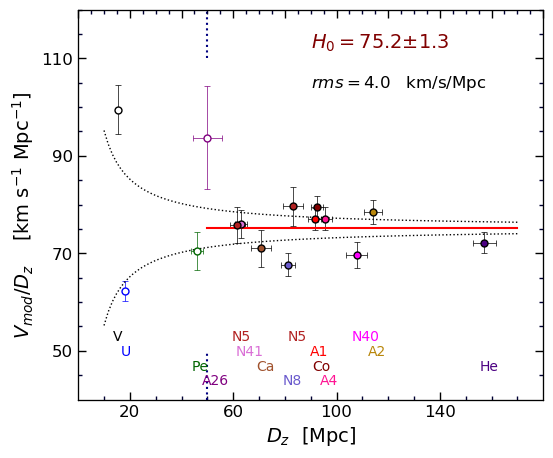

In [141]:
bandT = band
if band in ['w1', 'w2']:
    bandT=band.upper()

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

x_ax, y_ax = plotHubble(ax, labels=True)

ax.set_xlabel(r'$D_{'+bandT+'}$'+'  [Mpc]', fontsize=14)
ax.set_ylabel(r'$V_{mod}/D_{'+bandT+'}$'+'    [km s'+r'${^{-1}}$'+' Mpc'+r'${^{-1}}$'+']    ', fontsize=14)


In [12]:
def makeTFandPLOT(ax, band = 'i', xLim = (1.4,3.1), yLim = (18.75,7.25), manualInput=None):

    table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                            filling_values=-1, names=True, dtype=None, encoding=None)

    addSouth=False
    if band in ['w1', 'w2']:
        addSouth=True
    
    Clusters, slope0, zp0, slope_e0 = TF_iter(table, band = band, n_iter=10, verbose=False, 
                                                addSouth=addSouth, pgcFaint=I_maglim)

    zp_calibs = all_ZP(table, band=band, slope=slope0, pgcFaint=calib_maglim, manualInput=manualInput)
    slope = zp_calibs['slope']
    zp    = zp_calibs['zp']
    zp_e = zp_calibs['zp_e']

#     Clusters = allCluster(table, band=band, slope=slope, pgcFaint=I_maglim)

    dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}
    


    N_cluster = 0

    boolean = True
    for i, key in enumerate(Clusters):
            myCluster = Clusters[key]
            zp_ = myCluster['zp']
            I_mag = myCluster['mag']-zp_+zp
            logWimx = myCluster['logWimx']
            pgc =  myCluster['pgc']
            I_mag_w = myCluster['mag_w']-zp_+zp
            logWimx_w = myCluster['logWimx_w']    
            

            indx = []
            indx_ = []    
            for i, id in enumerate(pgc):
                if not id in I_maglim:
                    indx.append(i)
                else:
                    indx_.append(i)             

            if boolean:
                logWimx_=logWimx[indx]
                mag_=I_mag[indx]
                logWimx_e_=myCluster['logWimx_e'][indx]
                boolean = False
            else:                    
                logWimx_=np.concatenate((logWimx_, logWimx[indx]))
                mag_=np.concatenate((mag_, I_mag[indx]))
                logWimx_e_=np.concatenate((logWimx_e_, myCluster['logWimx_e'][indx]))               
                    
            alpha = 0.4
            if addSouth:
                alpha = 0.3
            
            ax.plot(logWimx[indx], I_mag[indx], '.', color=dye[band], alpha=alpha, 
                    ms=7, mec=dye[band])
            N_cluster += len(logWimx[indx])
            ax.plot(logWimx[indx_], I_mag[indx_], 'ko', alpha=0.3, markersize=5, markeredgecolor='none')        

            ax.plot(logWimx_w, I_mag_w, 'ko', alpha=0.3, 
                    ms=5, markeredgecolor='none')
            
            
    rms,RMS = rmsMaker(logWimx_, mag_, logWimx_e_, slope, zp)
    print band, len(logWimx_), N_cluster, '%.2f'%slope0, '%.2f'%slope_e0, '%.2f'%rms, '%.2f'%RMS

    m0 = zp_calibs['slope']
    b0 = zp_calibs['zp']
    dm0 = zp_calibs['slope_e']
    db0 = zp_calibs['zp_e']
    mag_ = zp_calibs['MAG']
    logWimx_ = zp_calibs['logWimx']
    mag_e = zp_calibs['mag_e']
    logWimx_e = zp_calibs['logWimx_e']
    pgc = zp_calibs['pgc']



    indx = []
    indx_ = []    
    for i, id in enumerate(pgc):
        if not id in calib_maglim:
            indx.append(i)
        else:
            indx_.append(i)  




    ax.plot(logWimx_[indx], mag_[indx], 'o',  
                            markersize=5, color = 'k', mew=0.7)
    N_calib = len(logWimx_[indx])

    if len(indx_)>0:
                ax.plot(logWimx_[indx_], mag_[indx_], 'o',  
                        color='k', markersize=5, alpha=1., markerfacecolor='white')


    x = np.linspace(-5,5,50)
    y = slope*(x-2.5)+zp
    ax.plot(x,y, 'k-')  

    if band=='i':
        x = np.linspace(1.6,2.4,20)
        ax.plot(x,-17*x/x,'--', lw=1, color='navy')
        ax.text(2.45,-16.8, r'$M_{i^*}=-17$'+' mag', fontsize=11, color='navy')
     
    if band=='w1':
        x = np.linspace(1.6,2.4,20)
        ax.plot(x,-16.1*x/x,'--', lw=1, color='navy')
        ax.text(2.38,-16.3, r'$M_{W1^*}=-16.1$'+' mag', fontsize=11, color='navy')

    ax.text(2.2,-13, "%d" % N_cluster+' Cluster Galaxies', fontsize=12, color='k')
    ax.text(2.2,-12, "%d" % N_calib+' Zeropoint Galaxies', fontsize=12, color='k')
    
    
    ax.set_xlim(xLim)        
    ax.set_ylim(yLim)
    ax.tick_params(which='major', length=6, width=1.5, direction='in')
    ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
    
    ax.set_xticks(np.arange(2.0, 3.5, step=0.5))
    
    if True:
        y_ax = ax.twinx()
        y_ax.set_ylim(yLim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

    if True:
        x_ax = ax.twiny()
        x_ax.set_xlim(xLim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     
        x_ax.set_xticks(np.arange(2.0, 3.5, step=0.5))


    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14)     

            
    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x0 = 0.95*Xlm[0]+0.05*Xlm[1]
    y0 = 0.2*Ylm[0]+0.80*Ylm[1]
    ax.text(x0,y0, "Slope = "+"%.2f" % slope0+'$\pm$'+"%.2f" % slope_e0, fontsize=12, color='k')
    y0 = 0.3*Ylm[0]+0.70*Ylm[1]
    ax.text(x0,y0, "ZP = "+"%.2f" % zp+'$\pm$'+"%.2f" % zp_e, fontsize=12, color='k')
    
    y0 = 0.1*Ylm[0]+0.9*Ylm[1]
    if addSouth:
        bandLab = band.upper()
    else:
        bandLab=band
    
    ax.text(x0,y0, "band: "+r'$'+bandLab+'$', fontsize=14, color='k')


In [13]:
fig = py.figure(figsize=(12, 10), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.97, bottom=0.07, left=0.06, right=0.98)
gs = gridspec.GridSpec(3, 3); p=0

manualInput = manualInput_cepheids

ax = plt.subplot(gs[p]); p+=1 
makeTFandPLOT(ax, band = 'u', xLim = (1.5,3.1), yLim = (-11,-25), manualInput=manualInput)
ax.set_ylabel(r'$M_{\lambda} \/\/ [AB]$', fontsize=18)


ax = plt.subplot(gs[p]); p+=1 
makeTFandPLOT(ax, band = 'i', xLim = (1.5,3.1), yLim = (-11,-25), manualInput=manualInput)
plt.setp(ax.get_yticklabels(), visible=False)

plt.title("Cepheids - Riess19", fontsize=20, color='red')

ax = plt.subplot(gs[p]); p+=1 
makeTFandPLOT(ax, band = 'w1', xLim = (1.5,3.1), yLim = (-11,-25), manualInput=manualInput)
plt.setp(ax.get_yticklabels(), visible=False)


ax = plt.subplot(gs[p]); p+=1 
makeTFandPLOT(ax, band = 'g', xLim = (1.5,3.1), yLim = (-11,-25), manualInput=manualInput)
ax.set_ylabel(r'$M_{\lambda} \/\/ [AB]$', fontsize=18)


ax = plt.subplot(gs[p]); p+=1 
makeTFandPLOT(ax, band = 'z', xLim = (1.5,3.1), yLim = (-11,-25), manualInput=manualInput)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 

ax = plt.subplot(gs[p]); p+=1 
makeTFandPLOT(ax, band = 'w2', xLim = (1.5,3.1), yLim = (-11,-25), manualInput=manualInput)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 

ax = plt.subplot(gs[p]); p+=1 
makeTFandPLOT(ax, band = 'r', xLim = (1.5,3.1), yLim = (-11,-25), manualInput=manualInput)
ax.set_ylabel(r'$M_{\lambda} \/\/ [AB]$', fontsize=18)
ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 

plt.subplots_adjust(hspace=0, wspace=0)



NameError: name 'manualInput_cepheids' is not defined

<Figure size 1200x1000 with 0 Axes>

In [145]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

Sqlt = table['Sqlt']
Wqlt = table['Wqlt']
pgc = table['pgc']

ctl   = np.genfromtxt('allzpa_labels.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
dist = 10**((ctl['dm19']-25)/5)  
manualInput_all = (PGC,ID,dist)

wise = 0
sdss = 0
both = 0
for idd in PGC:
    if idd in pgc:
        i, = np.where(pgc == idd)
        if Sqlt[i][0]>0:
            sdss+=1
        if Wqlt[i][0]>0:
            wise+=1
        if Sqlt[i][0]>0 and Wqlt[i][0]:
            both+=1

print sdss, wise, both
        
        
        


55 89 50
